In [753]:
import os.path
from typing import List
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from datetime import date
from thefuzz import fuzz

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 160

from utils.configuration import settings
from utils.utils import *
from tft.api import *

In [754]:
API_KEY: str = settings.api_key
ASSETS_DIR: str = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers' # challengers grandmasters
MAX_COUNT: int = settings.max_count
LATEST_RELEASE = '12.13.453.3037' # '12.12.450.4196''12.13.453.3037' Version 12.12.448.6653 12.11.446.9344 Version 12.13.453.3037 (Jul 11 2022/18:39:20) [PUBLIC] <Releases/12.13>
PATCH: date = date(2022, 7, 16)  # date(2022, 7, 1) date(2022, 7, 16)
THREEDAY: datetime = (datetime.now() - timedelta(days=3)).strftime("%Y-%m-%d")

TARGETNAME = 'placement'

# Data Loading

In [755]:
# raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_matches.pickle'))
raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{THREEDAY}_matches.pickle'))

# Preprocessing

In [756]:
def impute(df) -> DataFrame:
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

raw_df = impute(raw_df)

In [757]:
match_id_df: Series = raw_df['match_id']
X: DataFrame = raw_df.drop(['match_id'], axis=1)
y: Series = X.pop(TARGETNAME)
X.fillna('', inplace=True)
numeric_cols: List = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# traits level columns
traits_col: list = [s for s in numeric_cols if "Set7" in s]
# units level columns
units_col: list = [s for s in numeric_cols if "TFT7" in s]
# augments columns
augments_col: list[str] = ['augment0', 'augment1', 'augment2']
# units items columns
items_col = [s for s in categorical_cols if s not in augments_col]
df_unique = X.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
unique_items_set = {y for col in items_col for y in X[col].unique().tolist()}
unique_augments_set = {y for col in augments_col for y in X[col].unique().tolist()}
X[f'items_count'] = X[items_col].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X[f'traits_sum'] = X[traits_col].sum(axis=1)
X[f'units_sum'] = X[units_col].sum(axis=1)
X.iloc[X[f'units_sum'].idxmax()]

augment0           TFT7_Augment_MageConference
augment1          TFT6_Augment_TradeSectorPlus
augment2              TFT6_Augment_Meditation2
Set7_Assassin                              0.0
Set7_Astral                                1.0
                              ...             
TFT7_Zoe_item1                            None
TFT7_Zoe_item2                            None
items_count                                 11
traits_sum                                10.0
units_sum                                 27.0
Name: 3538, Length: 270, dtype: object

In [758]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

matches_df = X.copy()
matches_df[TARGETNAME] = y

# Augments Ranking

## Stage 2-1 augment ranking

In [759]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')
# group and aggregate mean/median
dct = {'Value_Count': ('augment0', 'count'), 'average_placement': ('placement', 'mean')}
augment0_rank_df = m.groupby('augment0', as_index=False).agg(**dct).sort_values(by='average_placement')
augment0_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_28428\207590299.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')


,augment0,Value_Count,average_placement
148,TFT7_Augment_Preparation3HR,3,1.333333
173,TFT7_Augment_TempestEmblem,1,2.000000
161,TFT7_Augment_ScalescornTrait,1,3.000000
129,TFT7_Augment_JadePenitence,6,3.000000
154,TFT7_Augment_RevelEmblem2,46,3.152174
128,TFT7_Augment_JadeEternalProtection,17,3.176471
73,TFT6_Augment_Twins2,113,3.292035
120,TFT7_Augment_GuardianTrait,6,3.333333
177,TFT7_Augment_ThinkFast,15,3.333333
80,TFT7_Augment_AssassinEmblem2,45,3.400000


In [760]:
augment0_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment0_ranking.csv'), index=False)

## Stage 3-2 augment ranking

In [761]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')
# group and aggregate mean/median
dct = {'Value_Count': ('augment1', 'count'), 'average_placement': ('placement', 'mean')}
augment1_rank_df = m.groupby('augment1', as_index=False).agg(**dct).sort_values(by='average_placement')
augment1_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_28428\1890264867.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')


,augment1,Value_Count,average_placement
155,TFT7_Augment_ScalescornEmblem,2,2.000000
156,TFT7_Augment_ScalescornEmblem2,1,2.000000
162,TFT7_Augment_ShimmerscaleSpending,3,2.333333
149,TFT7_Augment_RagewingTantrum,3,2.333333
76,TFT7_Augment_AssassinCutthroat,4,2.750000
122,TFT7_Augment_GuildGearUpgrades,11,3.090909
151,TFT7_Augment_RevelEmblem2,19,3.210526
128,TFT7_Augment_JadeTrait2,29,3.275862
70,TFT6_Augment_TriForce3,7,3.285714
17,TFT6_Augment_CyberneticUplink3,20,3.300000


In [762]:
augment1_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment1_ranking.csv'), index=False)

## Stage 4-2 augment ranking

In [763]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')
# group and aggregate mean/median
dct = {'Value_Count': ('augment2', 'count'), 'average_placement': ('placement', 'mean')}
augment2_rank_df = m.groupby('augment2', as_index=False).agg(**dct).sort_values(by='average_placement')
augment2_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_28428\3922423790.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')


,augment2,Value_Count,average_placement
63,TFT7_Augment_AssassinEmblem2,6,1.833333
104,TFT7_Augment_GuardianTrait,4,2.000000
136,TFT7_Augment_ScalescornEmblem2,2,2.500000
148,TFT7_Augment_SwiftshotTrait,11,3.000000
137,TFT7_Augment_ScalescornTrait,2,3.000000
132,TFT7_Augment_RevelPartyFavorsHR,1,3.000000
52,TFT6_Augment_TheGoldenEggHR,1,3.000000
151,TFT7_Augment_TempestEyeOfTheStorm,3,3.333333
139,TFT7_Augment_ShapeshifterTrait,15,3.333333
51,TFT6_Augment_TheGoldenEgg,75,3.466667


In [764]:
augment2_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment2_ranking.csv'), index=False)

# Items Ranking

In [689]:
def get_unit_items_ranking(df: matches_df, unit: str):
    # filter and melt the dataframe
    df = df.filter(regex=f'placement|{unit}_item0|{unit}_item1|{unit}_item2')
    df[f'unit'] = f'{unit}' # fill in current unit
    # join 3 items to 1 column
    df[f'{unit}_items'] = df[[f'{unit}_item0', f'{unit}_item1', f'{unit}_item2']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
    # sort items for unique combination
    df[f'{unit}_items'] = df[f'{unit}_items'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df = df.filter(regex=f'placement|{unit}_items|unit')
    m = df.melt(
        ['placement',f'unit'], value_name=f'{unit}_items_grp') #, value_vars=[f'{unit}_items', f'{unit}']
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'{unit}_items_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'unit', f'{unit}_items_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [690]:
get_unit_items_ranking(df = matches_df[:2], unit='TFT7_Zoe')

,unit,TFT7_Zoe_items_grp,value_count,average_placement
0,TFT7_Zoe,"None, None, None",2,5.5


In [691]:
# Get top5 value_count >= 12
top5_items_list = []
for unit in units_col:
    df = get_unit_items_ranking(df = matches_df, unit=unit)
    df = df[df['value_count']>=12][:5] #Top 5 with counts >= 12
    top5_items_list.extend(df.values)

In [692]:
top5_items_list = pd.DataFrame(top5_items_list, columns=['unit', 'items',	'value_count',	'average_placement'])

In [693]:
top5_items_list.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_top5_items.csv'), index=False)

## Top 1 items

In [ ]:
top5_items_list.groupby('unit').head(1)

,unit,items,value_count,average_placement
0,TFT7_Aatrox,"None, None, None",10074,4.496029
1,TFT7_Anivia,"None, None, None",9784,4.496423
3,TFT7_AoShin,"ArchangelsStaff, ArchangelsStaff, SpearOfShojin",21,2.380952
8,TFT7_Ashe,"None, None, Shroud",15,4.133333
13,TFT7_AurelionSol,"None, None, None",9928,4.498892
14,TFT7_Bard,"None, None, SeraphsEmbrace",26,2.807692
19,TFT7_Braum,"GargoyleStoneplate, None, None",16,4.187500
24,TFT7_Corki,"GuinsoosRageblade, MadredsBloodrazor, MadredsBloodrazor",13,3.923077
29,TFT7_Diana,"FrozenHeart, IonicSpark, RedBuff",27,3.037037
32,TFT7_DragonBlue,"GuinsoosRageblade, Quicksilver, RevelEmblemItem",25,2.320000


# Load TFT asset

In [ ]:
tft_assets = read_json(os.path.join(ASSETS_DIR, f'en_us.json'))

In [ ]:
tft7_set = tft_assets['setData'][6]['champions'] #['apiName'] ['traits']['name'] #['champions'] #['champions'].name

In [ ]:
champions_dict = {}

for champion in tft7_set:
    if champion["apiName"] not in champions_dict:
        champions_dict[champion["apiName"]] = []
    for trait in champion["traits"]:
        champions_dict[champion["apiName"]].append(trait)

In [ ]:
champions_dict['TFT7_Olaf']

['Scalescorn', 'Bruiser', 'Warrior']

# Team Composition Ranking

In [ ]:
def add_traits(units_str):
    # for units in units_str.split(', '):
    comp_array = []
    if len(units_str) == 0:
        return ''
    for unit in units_str.split(', '):
        traits_array = []
        for trait in champions_dict[unit]:
            traits_array.append(trait[:2]+trait[-1:]) # Add first 2 char for trait
        traits_str = '-'.join(traits_array) + f'-{unit}'
        comp_array.append(traits_str)

    # print(f'{"".join(comp_array)}')
    return ','.join(comp_array)

def get_unit_comp_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(row[row > 0].index.values.astype(str)), axis=1)
    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_','') # remove prefix .split('_',1).str[-1]
    df = df.filter(['placement', 'comp'])
    m = df.melt(
        ['placement'], value_name=f'comp_grp')
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'comp_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'comp_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [ ]:
# Get top5 
comp_df = get_unit_comp_ranking(df = matches_df)

In [ ]:
top5_comp_list = []
m = comp_df[comp_df['value_count']>=1] #[:5] #Top 5 with counts >= 12
top5_comp_list.extend(m.values)
comp_ranking_df = pd.DataFrame(top5_comp_list, columns=['comp', 'value_count', 'average_placement'])

In [ ]:
comp_ranking_df #.groupby('comp').head(1)

,comp,value_count,average_placement
0,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.0
1,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Asl-Swt-Varus,She-Spf-Mae-Zoe",1,1.0
2,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,1.0
3,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Jae-Str-Soraka,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.0
4,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Gud-Mae-Ryze,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,Asl-Mae-Vladimir,She-Spf-Mae-Zoe",1,1.0
...,...,...,...
5551,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,8.0
5552,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Gud-Car-Sejuani,Rag-Drr-Sett,Gud-Asn-Talon,Gud-Swt-Twitch",1,8.0
5553,"Jae-Evr-Led-Anivia,Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Jae-Gun-Taric",1,8.0
5554,"Jae-Evr-Led-Anivia,Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko",1,8.0


In [ ]:
composition_ranking_df = comp_ranking_df.copy()

# Team composition Clustering

In [ ]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

2022-07-17 14:36:14,641 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-07-17 14:36:14,836 [INFO] Use pytorch device: cpu


In [ ]:
corpus_sentences = list(comp_ranking_df['comp'])

corpus_embeddings = embedder.encode(corpus_sentences, batch_size=512, show_progress_bar=True, convert_to_tensor=True)
# Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

Batches: 100%|██████████| 11/11 [01:32<00:00,  8.38s/it]


In [ ]:
clustering_model = DBSCAN(eps=0.023, min_samples=1, metric='cosine', n_jobs=-1)
predict=clustering_model.fit_predict(corpus_embeddings)
comp_ranking_df['group'] = pd.Series(predict, index=comp_ranking_df.index)

In [ ]:
comp_ranking_df.sort_values(by='group')

,comp,value_count,average_placement,group
0,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.0,0
2336,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Tet-Drr-LeeSin,Jae-Shr-Neeko,Whs-Asn-Pyke,Mie-Drr-War-Yasuo",1,4.0,0
1452,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Tet-Drr-LeeSin,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Mie-Drr-War-Yasuo",2,3.0,0
1472,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Asn-Pyke,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,3.0,0
1,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Asl-Swt-Varus,She-Spf-Mae-Zoe",1,1.0,1
...,...,...,...,...
5547,"Jae-Evr-Led-Anivia,Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Drr-Karma,Trr-Myc-Evr-Lulu,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,She-Drr-Led-Volibear",1,8.0,1941
5549,"Tet-Drn-AoShin,Jae-Shr-Gnar,Tet-Drr-LeeSin,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Rel-Evr-Sona,Jae-Str-Soraka",1,8.0,1942
5551,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,8.0,1943
5552,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Gud-Car-Sejuani,Rag-Drr-Sett,Gud-Asn-Talon,Gud-Swt-Twitch",1,8.0,1944


In [ ]:
comp_ranking_df['grp_count'] = comp_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
comp_ranking_df['grp_placement'] = comp_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [ ]:
comp_ranking_df.sort_values(by='group')[:60]

,comp,value_count,average_placement,group,grp_count,grp_placement
0,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.000000,0,5,2.750000
2336,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Tet-Drr-LeeSin,Jae-Shr-Neeko,Whs-Asn-Pyke,Mie-Drr-War-Yasuo",1,4.000000,0,5,2.750000
1452,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Tet-Drr-LeeSin,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Mie-Drr-War-Yasuo",2,3.000000,0,5,2.750000
1472,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Asn-Pyke,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,3.000000,0,5,2.750000
1,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Asl-Swt-Varus,She-Spf-Mae-Zoe",1,1.000000,1,1,1.000000
1272,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,2.000000,2,3,2.333333
2,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,1.000000,2,3,2.333333
2429,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,4.000000,2,3,2.333333
3,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Jae-Str-Soraka,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.000000,3,1,1.000000
4,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Gud-Mae-Ryze,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,Asl-Mae-Vladimir,She-Spf-Mae-Zoe",1,1.000000,4,1,1.000000


In [ ]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [ ]:
def remove_traits(units_str):
    """Remove units traits from text seperated by comma

    Args:
        units_str (str): traits-unit,traits-unit

    Returns:
        str: Units stripped of traits
    """    
    if len(units_str) == 0:
        return ''

    units_array = []
    for unit in units_str.split(','):
        units_array.append(unit.split('-')[-1])
    units = ', '.join(units_array)
    return units

top_comp_ranking_df['comp'] = top_comp_ranking_df['comp'].apply(remove_traits)


In [ ]:
top_comp_ranking_df['mode'] = top_comp_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
top_comp_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,comp,value_count,average_placement,group,grp_count,grp_placement,mode
9,"Bard, Illaoi, Nami, Ornn, Ryze, Twitch, Varus, Zoe",1,1.000000,17,28,2.100000,"Bard, Ezreal, Illaoi, Nami, Sylas, Twitch, Varus, Zoe"
25,"Bard, Corki, DragonBlue, Ornn, Sona, TahmKench, Yasuo",1,1.000000,31,19,2.240741,"Bard, Corki, DragonBlue, Jinx, Lulu, Ornn, Sona, TahmKench"
51,"AoShin, Bard, Nami, Ornn, Pyke, Sylas, Zoe",1,1.000000,56,132,2.438650,"AoShin, Bard, Diana, Ornn, Pyke, Sylas, Zoe"
257,"AoShin, Bard, Heimerdinger, Lulu, Nami, Ornn, Soraka, Sylas, TrainerDragon, Zoe",1,1.000000,208,169,2.492801,"AoShin, Bard, Heimerdinger, Illaoi, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
211,"Bard, Diana, Lulu, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas",1,1.000000,167,26,2.543478,"Bard, Braum, Diana, Lillia, Olaf, Ornn, Pyke, Qiyana, Yasuo"
...,...,...,...,...,...,...,...
310,"AurelionSol, Illaoi, Lillia, Lulu, Nami, Sylas, Vladimir, Zoe",1,1.000000,239,12,6.136364,"AurelionSol, Illaoi, Lillia, Lulu, Nami, Sylas, Vladimir, Zoe"
1507,"AurelionSol, Illaoi, Lillia, Lulu, Nami, Ryze, Sylas, Vladimir",1,4.000000,814,11,6.166667,"AurelionSol, Illaoi, Lillia, Lulu, Nami, Ryze, Sylas, Vladimir"
1711,"AurelionSol, Illaoi, Nami, Nidalee, Skarner, Varus, Vladimir",13,4.384615,899,14,6.192308,"AurelionSol, Illaoi, Nami, Nidalee, Ryze, Skarner, Vladimir"
2082,"Heimerdinger, Illaoi, Lillia, Nami, Ryze, Soraka, Sylas, Vladimir",1,5.000000,1086,23,6.805556,"Heimerdinger, Illaoi, Lillia, Nami, Ryze, Sona, Sylas"


In [ ]:
comp_ranking_df['comp'] = comp_ranking_df['comp'].apply(remove_traits)
comp_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_comp_ranking.csv'), index=False)

In [ ]:
# from statistics import mode
# import jellyfish

# import pandas as pd

# df = pd.DataFrame({'Code': ['abc', 'abc', 'abc', 'abcc', 'abcc', 'zxc'],
#                    'Description': ['ABC String', 'abc string', 'ABC String and sth', 'abc sth else', 'zxc sth else', 'zxc zxc'],
#                 #    'Value': [10, 20, 30, 40, 100]
#                    })

# df_list = []
# for grp,df in df.groupby('Code'):
#     df['distance'] = df['Description'].apply(lambda x : fuzz.token_set_ratio(x, mode(df['Description'])))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [ ]:
# comp_ranking_df.groupby('comp')['comp'].apply(lambda x : fuzz.token_set_ratio(x, ','.join(units_col)))

In [ ]:
# df_list = []
# for grp,df in comp_ranking_df.groupby('comp'):
#     df['distance'] = df['comp'].apply(lambda x : fuzz.token_set_ratio(x, 'Aatrox, DragonGold, Kayn, Shen, Twitch, Xayah, Zoe'))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [ ]:
composition_ranking_df

,comp,value_count,average_placement
0,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.0
1,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Asl-Swt-Varus,She-Spf-Mae-Zoe",1,1.0
2,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,1.0
3,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Jae-Str-Soraka,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.0
4,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Gud-Mae-Ryze,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,Asl-Mae-Vladimir,She-Spf-Mae-Zoe",1,1.0
...,...,...,...
5551,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,8.0
5552,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Gud-Car-Sejuani,Rag-Drr-Sett,Gud-Asn-Talon,Gud-Swt-Twitch",1,8.0
5553,"Jae-Evr-Led-Anivia,Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Jae-Gun-Taric",1,8.0
5554,"Jae-Evr-Led-Anivia,Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko",1,8.0


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 644, cost: 9746.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16, cost: 9969.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 147, cost: 9171.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13, cost: 10013.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1732, cost: 9018.0
Best run was number 5
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 59, cost: 8421.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 13, cost: 7662.0
Init: initializing centroids
Init: initializing clusters
Starting iter

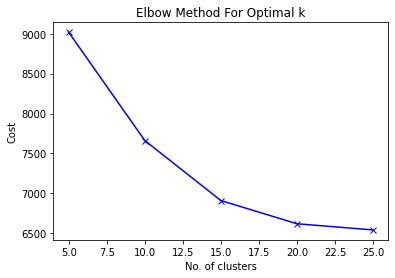

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(5,30,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(composition_ranking_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=10, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(composition_ranking_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 43, cost: 9475.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 664, cost: 7937.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 617, cost: 8467.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 47, cost: 8512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 8395.0
Best run was number 2


array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [ ]:
kmode_ranking_df = composition_ranking_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [ ]:
kmode_ranking_df

,group,comp,value_count,average_placement
0,0,"Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.0
1,0,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Tet-Brr-Led-Ornn,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Asl-Swt-Varus,She-Spf-Mae-Zoe",1,1.0
2,0,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,1.0
3,0,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Jae-Str-Soraka,Gud-Asn-Talon,Mie-Drr-War-Yasuo",1,1.0
4,0,"Tet-Drn-AoShin,Asl-Brr-Illaoi,Asl-Mae-Myc-Nami,Gud-Mae-Ryze,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,Asl-Mae-Vladimir,She-Spf-Mae-Zoe",1,1.0
...,...,...,...,...
5551,0,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,8.0
5552,0,"Tet-Drn-AoShin,Jae-Drr-Swt-Ashe,Tet-Drr-LeeSin,Gud-Car-Sejuani,Rag-Drr-Sett,Gud-Asn-Talon,Gud-Swt-Twitch",1,8.0
5553,0,"Jae-Evr-Led-Anivia,Jae-Drr-Swt-Ashe,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Jae-Gun-Taric",1,8.0
5554,0,"Jae-Evr-Led-Anivia,Jae-Drr-Swt-Ashe,Gud-Myc-Bad-Bard,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko",1,8.0


In [ ]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [ ]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [ ]:
kmode_ranking_df['comp'] = kmode_ranking_df['comp'].apply(remove_traits)
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,group,comp,value_count,average_placement,grp_count,grp_placement,mode
663,3,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Sylas, Talon, TrainerDragon, Twitch, Varus",1,2.0,736,2.000000,"Aatrox, AoShin, Bard, Corki, Lulu, Ornn, Talon, Volibear, Zoe"
858,8,"AoShin, Bard, Braum, Neeko, Ornn, Shyvana, Yasuo",1,2.0,1,2.000000,"AoShin, Bard, Braum, Neeko, Ornn, Shyvana, Yasuo"
1371,2,"DragonBlue, Lillia, Nunu, Ryze, Vladimir, Yasuo, Yone",1,3.0,688,3.000000,"Aatrox, Bard, Diana, DragonGold, Kayn, Qiyana, Soraka, Zoe"
75,4,"Bard, Illaoi, Lulu, Nami, Pyke, Ryze, Sona, Sylas, Zoe",2,1.0,688,4.281437,"Aatrox, Braum, Leona, Olaf, Shen, Thresh, Yone"
602,6,"Bard, Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah, Yasuo",5,1.4,240,4.374468,"Anivia, Hecarim, LeeSin, Nunu, Ornn, Sejuani, Volibear, Yasuo"
0,0,"Ashe, DragonGreen, Gnar, Neeko, Pyke, Qiyana, Talon, Yasuo",1,1.0,5783,4.604242,
2787,7,"Illaoi, Nami, Soraka, Sylas, Twitch, Varus, Yasuo, Zoe",1,5.0,576,5.000000,"Aatrox, Braum, Diana, Lillia, Olaf, Shen, Yone"
3401,5,"Ezreal, Illaoi, Ornn, Skarner, Sylas, Twitch, Varus",2,5.5,148,5.500000,"Aatrox, DragonGold, Kayn, Swain, Volibear, Xayah, Yasuo"
3489,9,"DragonGold, Hecarim, Kayn, Pyke, Talon, Volibear, Zoe",1,6.0,578,6.000000,"Aatrox, Ashe, DragonGold, Kayn, Swain, Volibear, Xayah"
4146,1,"Corki, Jinx, Lulu, Ornn, Shen, Sona, TrainerDragon, Tristana",1,7.0,706,7.000000,"Aatrox, Anivia, DragonGold, Kayn, Ornn, Volibear, Zoe"


In [ ]:
def get_unit_composition(df: matches_df):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col+traits_col)
    return df.sort_values(by='placement')

In [ ]:
units_comp_df:DataFrame = get_unit_composition(matches_df)

In [ ]:
units_comp_df

,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,TFT7_Diana,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
9517,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3261,1,0,2,0,0,0,2,0,0,0,...,0,1,0,0,1,0,0,0,0,0
9860,1,0,0,0,0,0,1,0,2,0,...,0,0,2,1,0,0,0,1,0,0
5333,1,0,0,2,0,0,2,0,0,0,...,0,0,0,1,0,0,2,0,0,1
5336,1,0,0,0,0,0,0,2,2,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4560,8,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
8835,8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4508,8,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## KMode

In [ ]:
units_composition_df = units_comp_df.copy()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3503, cost: 111152.0
Run 1, iteration: 2/100, moves: 743, cost: 110479.0
Run 1, iteration: 3/100, moves: 88, cost: 110479.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4693, cost: 112331.0
Run 2, iteration: 2/100, moves: 457, cost: 112256.0
Run 2, iteration: 3/100, moves: 10, cost: 112256.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2542, cost: 113064.0
Run 3, iteration: 2/100, moves: 860, cost: 112595.0
Run 3, iteration: 3/100, moves: 409, cost: 112341.0
Run 3, iteration: 4/100, moves: 95, cost: 112341.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3757, cost: 111373.0
Run 4, iteration: 2/100, moves: 782, cost: 111232.0
Run 4, iteration: 3/100, moves: 11, cost: 111232.0
Init

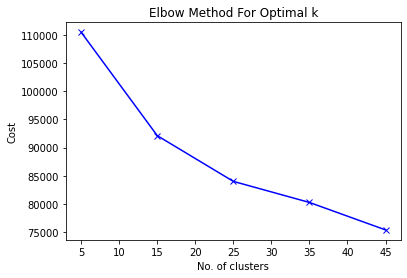

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(5,50,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(units_composition_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=25, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(units_composition_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3623, cost: 88516.0
Run 1, iteration: 2/100, moves: 1727, cost: 86424.0
Run 1, iteration: 3/100, moves: 773, cost: 85994.0
Run 1, iteration: 4/100, moves: 82, cost: 85978.0
Run 1, iteration: 5/100, moves: 2, cost: 85978.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3139, cost: 87176.0
Run 2, iteration: 2/100, moves: 921, cost: 86945.0
Run 2, iteration: 3/100, moves: 112, cost: 86863.0
Run 2, iteration: 4/100, moves: 96, cost: 86749.0
Run 2, iteration: 5/100, moves: 39, cost: 86737.0
Run 2, iteration: 6/100, moves: 4, cost: 86737.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3606, cost: 86753.0
Run 3, iteration: 2/100, moves: 1115, cost: 86218.0
Run 3, iteration: 3/100, moves: 229, cost: 86132.0
Run 3, iteration: 4/100, moves: 105, cost: 86110

array([23, 15,  0, ...,  6, 10,  7], dtype=uint16)

In [ ]:
kmode_ranking_df = units_composition_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [ ]:
kmode_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
9517,23,1,0,0,0,2,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3261,15,1,0,2,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,0
9860,0,1,0,0,0,0,0,1,0,2,...,0,0,2,1,0,0,0,1,0,0
5333,3,1,0,0,2,0,0,2,0,0,...,0,0,0,1,0,0,2,0,0,1
5336,5,1,0,0,0,0,0,0,2,2,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,10,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4560,12,8,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
8835,6,8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4508,10,8,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
def get_unit_composition_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement', 'group']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(
        row[row > 0].index.values.astype(str)), axis=1)

    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_', '')
    df = df.filter(['placement', 'group', 'comp'])
    return df.sort_values(by='group')

In [ ]:
kmode_ranking_df = get_unit_composition_ranking(kmode_ranking_df, add_trait=False)

In [ ]:
kmode_ranking_df

,placement,group,comp
4343,3,0,"Bard, Corki, DragonPurple, Lulu, Ornn, Pyke, Sona, TrainerDragon, Tristana"
6756,5,0,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana"
3447,1,0,"Bard, Corki, DragonGold, Jinx, Lulu, Sona, Soraka, TrainerDragon, Tristana"
9031,8,0,"Bard, Corki, DragonGold, Jinx, Lulu, Sona, Thresh"
5570,4,0,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana"
...,...,...,...
3981,3,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
2923,8,24,"Hecarim, Ornn, Ryze, Sejuani, Shen, Talon, Twitch, Xayah"
5184,4,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
2392,8,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"


In [ ]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [ ]:
kmode_ranking_df

,placement,group,comp,grp_count,grp_placement
4343,3,0,"Bard, Corki, DragonPurple, Lulu, Ornn, Pyke, Sona, TrainerDragon, Tristana",587,3.795571
6756,5,0,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana",587,3.795571
3447,1,0,"Bard, Corki, DragonGold, Jinx, Lulu, Sona, Soraka, TrainerDragon, Tristana",587,3.795571
9031,8,0,"Bard, Corki, DragonGold, Jinx, Lulu, Sona, Thresh",587,3.795571
5570,4,0,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana",587,3.795571
...,...,...,...,...,...
3981,3,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",173,6.358382
2923,8,24,"Hecarim, Ornn, Ryze, Sejuani, Shen, Talon, Twitch, Xayah",173,6.358382
5184,4,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",173,6.358382
2392,8,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",173,6.358382


In [ ]:
top5_comp_ranking_list = []
m = kmode_ranking_df[kmode_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_kmode_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['placement', 'group', 'comp', 'grp_count', 'grp_placement'])

In [ ]:
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
5084,3,3,"AoShin, Bard, Hecarim, Nunu, Ornn, Shen, Soraka",504,2.690476,"AoShin, Bard, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
604,2,2,"Bard, Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",327,3.324159,"Bard, Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
5949,3,16,"Bard, Heimerdinger, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir, Yasuo, Zoe",423,3.498818,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Zoe"
5521,2,20,"Kayn, Neeko, Ornn, Pyke, Qiyana, Shyvana, Talon, Yasuo",549,3.752277,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
4343,3,0,"Bard, Corki, DragonPurple, Lulu, Ornn, Pyke, Sona, TrainerDragon, Tristana",587,3.795571,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana"
3491,6,15,"Anivia, Bard, Corki, Neeko, Senna, Shyvana, Sona",274,3.963504,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Soraka"
6468,3,6,"AoShin, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Yasuo, Zoe",514,4.167315,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sona, Sylas, TrainerDragon, Zoe"
8420,2,8,"Bard, DragonBlue, Hecarim, Nunu, Shen, Sylas, Yasuo, Yone",578,4.205882,"DragonBlue, Hecarim, Lillia, Nunu, Sejuani, Yasuo, Yone"
6432,6,9,"Hecarim, Olaf, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",645,4.257364,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
3589,3,18,"Elise, Neeko, Shen, Shyvana, Swain, Twitch, Xayah",164,4.268293,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"


## KMeans

In [ ]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

9517    1
3261    1
9860    1
5333    1
5336    1
       ..
4553    8
4560    8
8835    8
4508    8
9016    8
Name: placement, Length: 10144, dtype: int64

In [ ]:
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
kms = KMeans(n_clusters=num_clusters, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)

Initialization complete
Iteration 0, inertia 3693.923151177887.
Iteration 1, inertia 2593.3147403898483.
Iteration 2, inertia 2544.5958519677947.
Iteration 3, inertia 2516.5876957253554.
Iteration 4, inertia 2494.996527241014.
Iteration 5, inertia 2478.700267037015.
Iteration 6, inertia 2471.7645240956545.
Iteration 7, inertia 2465.6368174346617.
Iteration 8, inertia 2462.3966076416573.
Iteration 9, inertia 2461.5004950791354.
Iteration 10, inertia 2460.988297924438.
Iteration 11, inertia 2460.590108444356.
Iteration 12, inertia 2460.1693043618757.
Iteration 13, inertia 2459.734575802174.
Iteration 14, inertia 2459.451649605543.
Iteration 15, inertia 2459.2871713852855.
Iteration 16, inertia 2459.2353699661817.
Iteration 17, inertia 2459.1952933773923.
Iteration 18, inertia 2459.1724014589054.
Iteration 19, inertia 2459.1648366195222.
Iteration 20, inertia 2459.1574442641263.
Iteration 21, inertia 2459.150436649136.
Iteration 22, inertia 2459.1418176000566.
Iteration 23, inertia 2459.1

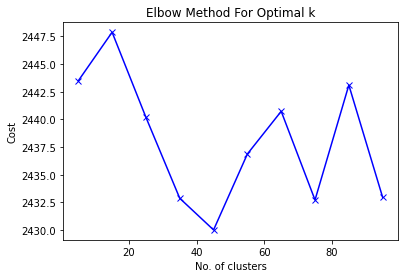

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(5,100,10)
for num_clusters in list(K):
    kmeans.fit_predict(X)
    cost.append(kmeans[-1].inertia_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Building the model with 25 clusters
kms = KMeans(n_clusters=25, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)
clusters = kmeans.fit_predict(X)
clusters

Initialization complete
Iteration 0, inertia 4576.245432906987.
Iteration 1, inertia 3056.83487951564.
Iteration 2, inertia 2996.1578325473106.
Iteration 3, inertia 2975.792305606957.
Iteration 4, inertia 2966.0380713147674.
Iteration 5, inertia 2960.6385806035496.
Iteration 6, inertia 2957.6057880261255.
Iteration 7, inertia 2953.477379550449.
Iteration 8, inertia 2942.759689597035.
Iteration 9, inertia 2935.6579959896826.
Iteration 10, inertia 2933.9192320187967.
Iteration 11, inertia 2933.5051360444063.
Iteration 12, inertia 2933.371231675425.
Iteration 13, inertia 2933.2333562003014.
Iteration 14, inertia 2933.1895763902526.
Iteration 15, inertia 2933.1775049846447.
Iteration 16, inertia 2933.1703553660304.
Iteration 17, inertia 2933.1613701200195.
Iteration 18, inertia 2933.1541706788075.
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 4491.774142416029.
Iteration 1, inertia 3061.0489428908522.
Iteration 2, inertia 2992.5166943892937.
It

array([ 7, 16,  2, ..., 14, 14,  5])

In [ ]:
kmeans_ranking_df = units_composition_df.copy()
kmeans_ranking_df.insert(0, "group", clusters, True)

In [ ]:
kmeans_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
9517,7,1,0,0,0,2,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3261,16,1,0,2,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,0
9860,2,1,0,0,0,0,0,1,0,2,...,0,0,2,1,0,0,0,1,0,0
5333,1,1,0,0,2,0,0,2,0,0,...,0,0,0,1,0,0,2,0,0,1
5336,17,1,0,0,0,0,0,0,2,2,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,5,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4560,13,8,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
8835,14,8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4508,14,8,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
kmeans_ranking_df = get_unit_composition_ranking(kmeans_ranking_df, add_trait=False)

In [ ]:
kmeans_ranking_df

,placement,group,comp
3335,6,0,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
1320,5,0,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
1333,3,0,"Hecarim, Ornn, Qiyana, Sejuani, Soraka, Talon, Twitch, Xayah"
9356,5,0,"Bard, Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
5151,5,0,"Hecarim, Ornn, Qiyana, Shen, Talon, Twitch, Xayah, Yasuo"
...,...,...,...
5059,4,24,"AoShin, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
9235,4,24,"AoShin, Heimerdinger, Illaoi, Lulu, Ornn, Shen, Sylas, TrainerDragon"
10059,7,24,"AoShin, Heimerdinger, Lulu, Nami, Ornn, Sona, Sylas, TrainerDragon"
4808,1,24,"AoShin, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Yasuo, Zoe"


In [ ]:
kmeans_ranking_df['grp_count'] = kmeans_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmeans_ranking_df['grp_placement'] = kmeans_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [ ]:
kmeans_ranking_df['mode'] = kmeans_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmeans_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
10105,5,24,"AoShin, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe",417,3.194245,"AoShin, Bard, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
4913,4,1,"AoShin, Gnar, LeeSin, Neeko, Qiyana, Soraka, Yasuo",303,3.475248,"AoShin, Bard, Lulu, Nami, Ornn, Sylas, Zoe"
7644,2,19,"Diana, Lillia, Olaf, Ornn, Qiyana, Shen, Talon",359,3.947075,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
1149,7,4,"DragonPurple, Olaf, Ornn, Qiyana, Shen, Sylas, Talon",534,4.297753,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
3861,6,11,"DragonBlue, Hecarim, Heimerdinger, Lulu, Nunu, Sejuani, TrainerDragon",474,4.324895,"DragonBlue, Hecarim, Lillia, Nunu, Sejuani, Yasuo, Yone"
6006,6,8,"DragonGreen, Elise, Gnar, Neeko, Nidalee, Taric, Thresh",378,4.359788,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
899,5,14,"Heimerdinger, Illaoi, Lillia, Lulu, Nami, Ryze, Sylas, TrainerDragon",606,4.394389,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Zoe"
9683,8,9,"Illaoi, Lulu, Nami, Ryze, Sylas, Twitch, Varus",581,4.425129,"Heimerdinger, Illaoi, Lulu, Nami, Sylas, TrainerDragon, Twitch, Varus"
3335,6,0,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",1237,4.455942,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
3390,3,20,"DragonPurple, Illaoi, Ornn, Sejuani, Sylas, Twitch, Varus",457,4.505470,"Ezreal, Illaoi, Ornn, Shen, Skarner, Twitch, Varus, Xayah"


In [ ]:
kmeans_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_kmeans_comp_ranking.csv'), index=False)

## DBSCAN

In [ ]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

9517    1
3261    1
9860    1
5333    1
5336    1
       ..
4553    8
4560    8
8835    8
4508    8
9016    8
Name: placement, Length: 10144, dtype: int64

In [ ]:
units_composition_df.shape

(10144, 88)

In [ ]:
# Building the model with 3 clusters
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
dbs= DBSCAN(eps=0.37, metric='euclidean', min_samples=3, n_jobs=-1) #eps=0.053, metric='cosine'
dbscan = make_pipeline(normalizer, dbs)
clusters = dbscan.fit_predict(X)
clusters

array([-1,  0, 89, ...,  3, -1, -1], dtype=int64)

In [ ]:
dbscan_ranking_df = units_composition_df.copy()
dbscan_ranking_df.insert(0, "group", clusters, True)

In [ ]:
dbscan_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
9517,-1,1,0,0,0,2,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3261,0,1,0,2,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,0
9860,89,1,0,0,0,0,0,1,0,2,...,0,0,2,1,0,0,0,1,0,0
5333,1,1,0,0,2,0,0,2,0,0,...,0,0,0,1,0,0,2,0,0,1
5336,2,1,0,0,0,0,0,0,2,2,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,3,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4560,-1,8,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
8835,3,8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4508,-1,8,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
dbscan_ranking_df = get_unit_composition_ranking(dbscan_ranking_df, add_trait=False)

In [ ]:
dbscan_ranking_df

,placement,group,comp
9517,1,-1,"Ashe, DragonGreen, Karma, LeeSin, Neeko, Ornn, Sett, Shen, Swain"
6696,5,-1,"Ezreal, Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch"
6315,5,-1,"AoShin, Heimerdinger, Illaoi, Lulu, Nami, Ornn, TrainerDragon, Vladimir"
3906,5,-1,"Bard, DragonPurple, Nami, Ryze, Sylas, Vladimir, Zoe"
6704,5,-1,"AoShin, Bard, Illaoi, Ornn, Qiyana, Shen, Sylas, TahmKench"
...,...,...,...
8781,8,115,"DragonGold, Kayn, Neeko, Sett, Swain, Volibear"
6931,8,115,"DragonGold, Kayn, Neeko, Sett, Swain, Volibear"
1820,5,116,"DragonBlue, DragonGold, Leona, Nunu, Soraka, Yasuo"
4267,5,116,"DragonBlue, DragonGold, Leona, Nunu, Yasuo, Yone"


In [ ]:
dbscan_ranking_df['grp_count'] = dbscan_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
dbscan_ranking_df['grp_placement'] = dbscan_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')
dbscan_ranking_df['mode'] = dbscan_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
dbscan_ranking_df.groupby(['group']).head(1).sort_values(by='grp_count', ascending=False)[:60]

,placement,group,comp,grp_count,grp_placement,mode
4436,2,0,"Anivia, Bard, DragonGreen, Gnar, Lulu, Nami, Neeko, Yasuo",3142.0,4.686047,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Soraka"
6527,6,4,"DragonPurple, Ornn, Qiyana, Shen, Sylas, Talon, Yasuo",1551.0,4.216374,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
5474,1,3,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Zoe",1271.0,4.082527,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir"
1504,6,6,"DragonBlue, Hecarim, Leona, Lulu, Nunu, Sejuani, Yone",1084.0,4.310924,"DragonBlue, Hecarim, Lillia, Nunu, Sejuani, Yasuo, Yone"
1060,6,10,"Diana, Illaoi, Olaf, Ornn, Pyke, Qiyana, Shen, Talon",696.0,3.778135,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
3343,2,7,"Bard, DragonGreen, Gnar, Neeko, Pyke, Soraka, Talon, Yasuo",357.0,2.857143,"Bard, DragonGreen, Gnar, Neeko, Pyke, Soraka, Talon, Yasuo"
2080,5,5,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",342.0,4.399446,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
9193,5,11,"DragonGreen, Elise, Gnar, Neeko, Nidalee, Soraka, Thresh",311.0,4.150198,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
5099,3,12,"Illaoi, Ornn, Qiyana, Talon, Twitch, Varus",253.0,2.666667,"Illaoi, Ornn, Qiyana, Talon, Twitch, Varus"
7069,3,1,"AoShin, Bard, Ornn, Ryze, Soraka, Sylas, Zoe",172.0,1.884615,"AoShin, Bard, Ornn, Ryze, Soraka, Sylas, Yasuo, Zoe"


In [ ]:
dbscan_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_dbscan_comp_ranking.csv'), index=False)